## Paper : Time Series Prediction via Recurrent Neural Networks with the Information Bottleneck Principle

## Proposed Methods

### • Gated Recurrent Unit:
It has gating units that modulate the information flow inside the unit, but without having a separate memory cell:

\begin{align*}
r_t &= \sigma(W_r x_t + U_r h_{t-1} + b_r) \\
u_t &= \sigma(W_u x_t + U_u h_{t-1} + b_u) \\
c_t &= \tanh(W_c x_t + U_c (r_t \odot h_{t-1}) + b_c) \\
h_t &= u_t \odot h_{t-1} + (1 - u_t) \odot c_t
\end{align*}

with the input $ x_t $, the hidden state of GRU cell $ h_t $, the reset gate $ r_t $, the forgetting gate $ u_t $, and candidate activation $ c_t $.

### • Information Bottleneck:
It is an information-theoretic view of deep neural networks.  
Assuming:
- Input random variable: $ X $
- Latent state: $ Z $
- Target: $ Y $

The Markov chain $ Y \leftrightarrow X \leftrightarrow Z $ holds.

- The aim is to make latent $ Z $ informative about target $ Y $, i.e., to **maximize mutual information** $ I(Z, Y) $.
- To obtain a low-complexity representation of input, we assume $ I(X, Z) \leq \epsilon $, where $ \epsilon $ is a predefined threshold.

The optimization problem is formulated as:

$$
\max_{\theta} I(Z, Y; \theta) \quad \text{s.t.} \quad I(X, Z; \theta) < \epsilon
$$

By introducing Lagrange multiplier $ \beta \geq 0 $, we get the following objective:

$$
L_{IB}(\theta) = I(Z, Y; \theta) - \beta I(Z, X; \theta)
$$

### • Recurrent Information Bottleneck:
Information Bottleneck is extended to recurrent models.

- We use **multivariate Gaussian distribution** as a variational approximation.
- Temporal dependencies are modeled using the hidden states of the GRU.

The objective function is:

$$
\frac{1}{N} \sum_{n=1}^{N} \left[ \sum_{t=1}^{T} \int p(z_{nt} | x_{nt}) \log q(y_{nt} | z_{nt}) \, dz_{nt} 
\quad - \beta \int p(z_{nt} | x_{nt}) \log \frac{p(z_{nt} | x_{nt})}{\tilde{p}_t(z_{nt})} \, dz_{nt} \right]
$$


## Proposed Model

<p align="center">
  <img src="https://raw.githubusercontent.com/sarakpyny/CREST-Internship/main/img/rib_paper/rib_architecture.png" width="400"/>
</p>

- In our model, the input is first encoded to a latent state $ \mathbf{z}_t $, which is then fed into a GRU for state transition.
- $ \mathbf{z}_t $ is then decoded together with the hidden state to generate the output.
- The dashed lines in the diagram show the conditional dependency in both the prior of $ \mathbf{z}_t $ and the encoding of the input.

### • Encoding Distribution:
$$
Z_t \sim \mathcal{N}\left( \mu_{\text{enc}}(x_t, h_{t-1}), \, \operatorname{diag}\left(\sigma^2_{\text{enc}}(x_t, h_{t-1})\right) \right)
$$

### • Decoding Distribution:
$$
\hat{Y}_t \sim \mathcal{N}\left( \mu_{\text{dec}}(z_t, h_{t-1}), \, \operatorname{diag}\left(\sigma^2_{\text{dec}}(z_t, h_{t-1})\right) \right)
$$

### • Prior of Latent $ \mathbf{z}_t $:
$$
\tilde{p}(z_t \mid h_{t-1}) = \mathcal{N}\left( \mu_{\text{prior}}(h_{t-1}), \, \operatorname{diag}\left(\sigma^2_{\text{prior}}(h_{t-1})\right) \right)
$$

- All mean and variance functions here are realized by multi-layer neural networks.
- In the GRU cell, the hidden state is updated following standard GRU operations.


## Experiments

### • Sunspot Dataset:

- The first experiment uses the **sunspot dataset**, which contains sunspot numbers collected in Zurich from **Jan. 1749 to Dec. 1983**.
- We use the first **1000 data points for training** and 1000 for testing.

The $ (1 - \alpha) $-level **confidence interval** of the prediction is:

$$
\left[
\mu_{\text{dec}} - z_{1 - \alpha/2} \sqrt{\sigma^2_{\text{dec}}},
\quad
\mu_{\text{dec}} + z_{1 - \alpha/2} \sqrt{\sigma^2_{\text{dec}}}
\right]
$$

#### Prediction Plot:
<p align="center">
  <img src="https://raw.githubusercontent.com/sarakpyny/CREST-Internship/main/img/rib_paper/result_paper.png" width="600"/>
</p>

#### Performance Comparison:

|          | Proposed | RBM    | SAE    | LSTM   |
|----------|----------|--------|--------|--------|
| **MAE**  | 0.0453   | 0.0911 | 0.116  | 0.0524 |
| **RMSE** | 0.0612   | 0.132  | 0.150  | 0.0739 |



### • Traffic Data:

- The second experiment uses **traffic data**: 15 months of daily data from California’s Department of Transportation.
- The dataset describes **occupancy rates** of **963 freeways** in the Bay Area.

#### Performance Comparison:

|          | Proposed | MatFact | VRNN   | SAE    |
|----------|----------|---------|--------|--------|
| **NMAE** | 0.1127   | 0.1935  | 0.2103 | 0.2234 |
| **NMRSE**| 0.3608   | 0.4263  | 0.4312 | 0.4566 |



### Conclusion

- We propose to use the **information bottleneck** to model time series **probabilistically**.
- This method achieves **better prediction performance** than previous approaches.


## Implementation code

### Dara preparation

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

from scipy.stats import norm

In [2]:
# load data
df = pd.read_csv('data/Sunspots.csv')
df

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8


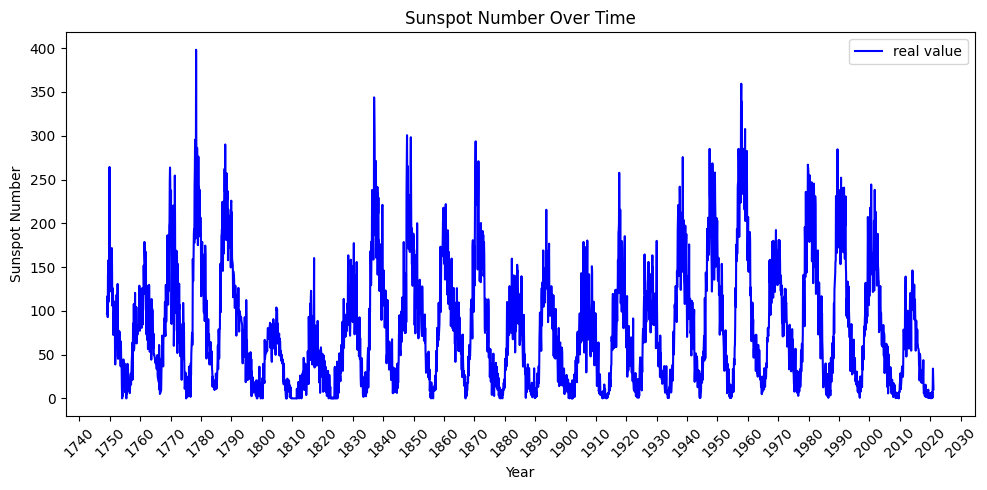

In [ ]:
# load data
df = pd.read_csv('data/Sunspots.csv')

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Monthly Mean Total Sunspot Number'], 'b', label='real value')

# Set x-axis to show major ticks every 10 years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(10))  # every 10 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Improve x-axis appearance
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Number Over Time')
plt.legend()
plt.tight_layout()
plt.show()


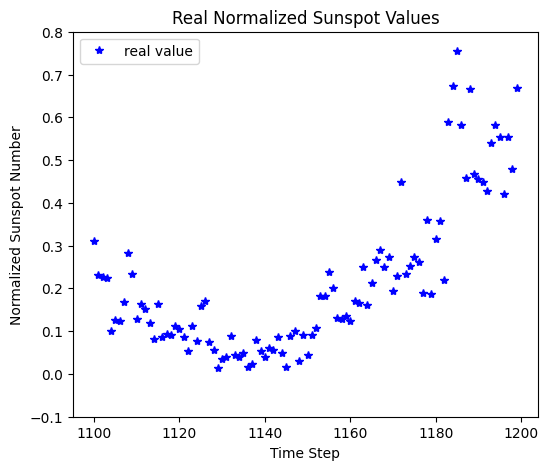

In [5]:
# Check if it corresponds to the paper's data
sunspot_series = df['Monthly Mean Total Sunspot Number'].values

# Normalize to [0, 1]
scaled = (sunspot_series - np.min(sunspot_series)) / (np.max(sunspot_series) - np.min(sunspot_series))

# Take the desired window, index 1100–1200 (as per the paper)
x_range = range(1100, 1200)
y_values = scaled[1100:1200]

# Plot real values only
plt.figure(figsize=(6, 5))
plt.plot(x_range, y_values, 'b*', label='real value')

plt.xlabel('Time Step')
plt.ylabel('Normalized Sunspot Number')
plt.title('Real Normalized Sunspot Values')
plt.ylim(-0.1, 0.8)  # Optional: match the paper
plt.legend()
plt.show()

In [3]:
# convert 'Date' column to datetime and filter the DataFrame
df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[(df['Date'] >= '1749-01-01') & (df['Date'] <= '1983-12-31')].reset_index(drop=True)

# rename columns
df_filtered.rename(columns={'Monthly Mean Total Sunspot Number': 'Sunspots'}, inplace=True)

# select columns
df_filtered = df_filtered[['Date', 'Sunspots']].iloc[:2000]

# Convert to numpy array and reshape for scaling
values = df_filtered['Sunspots'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values).flatten()

# split the data into train and test sets
train_seq = scaled_values[:1000]
test_seq = scaled_values[1000:2000]

# Ensure the sequences are of the same length
X_train = torch.tensor(train_seq[:-1]).unsqueeze(0).float()  # [1, 999]
Y_train = torch.tensor(train_seq[1:]).unsqueeze(0).float()   # [1, 999]

X_val = torch.tensor(test_seq[:-1]).unsqueeze(0).float()
Y_val = torch.tensor(test_seq[1:]).unsqueeze(0).float()

print(f"Train X: {X_train.shape}, Train Y: {Y_train.shape}")
print(f"Val X: {X_val.shape}, Val Y: {Y_val.shape}")

# Create DataLoader for training and validation sets
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=1, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=1, shuffle=False)

Train X: torch.Size([1, 999]), Train Y: torch.Size([1, 999])
Val X: torch.Size([1, 999]), Val Y: torch.Size([1, 999])


## Model Architecture

In [4]:
# Step 1 : Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, z_dim * 2)  
        )

    def forward(self, x_t, h_prev):
        inp = torch.cat([x_t, h_prev], dim=-1)
        stats = self.fc(inp)
        mu, logvar = stats.chunk(2, dim=-1)
        return mu, logvar

# Step 2 : Prior
class Prior(nn.Module):
    def __init__(self, hidden_dim, z_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, z_dim * 2)
        )

    def forward(self, h_prev):
        stats = self.fc(h_prev)
        mu, logvar = stats.chunk(2, dim=-1)
        return mu, logvar

# Step 3 : Decoder
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim + hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  
        )

    def forward(self, z_t, h_prev):
        inp = torch.cat([z_t, h_prev], dim=-1)
        stats = self.fc(inp)
        mu, logvar = stats.chunk(2, dim=-1)
        return mu, logvar

# Reparameterization trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Step 4 : RIB_GRU_Model
class RIB_GRU_Model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, z_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim

        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.prior = Prior(hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        self.gru_cell = nn.GRUCell(z_dim, hidden_dim)

    def forward(self, x_t, h_prev):
        # Encoder
        mu_enc, logvar_enc = self.encoder(x_t, h_prev)
        z_t = reparameterize(mu_enc, logvar_enc)

        # Prior
        mu_prior, logvar_prior = self.prior(h_prev)

        # Decoder
        mu_dec, logvar_dec = self.decoder(z_t, h_prev)

        # GRU update
        h_t = self.gru_cell(z_t, h_prev)

        return {
            'z_t': z_t,
            'mu_enc': mu_enc, 'logvar_enc': logvar_enc,
            'mu_prior': mu_prior, 'logvar_prior': logvar_prior,
            'mu_dec': mu_dec, 'logvar_dec': logvar_dec,
            'h_t': h_t
        }
    
# Loss function
LOG_2PI = torch.tensor(np.log(2.0 * np.pi))

def rib_loss(outputs, y_t, beta=0.005):
    
    mu_enc = outputs['mu_enc']
    logvar_enc = outputs['logvar_enc']
    mu_prior = outputs['mu_prior']
    logvar_prior = outputs['logvar_prior']
    mu_dec = outputs['mu_dec']
    logvar_dec = outputs['logvar_dec']

    log_2pi = LOG_2PI.to(y_t.device) 

    # Decoder Gaussian NLL
    var_dec = logvar_dec.exp()
    nll = 0.5 * (log_2pi + logvar_dec + ((y_t - mu_dec) ** 2) / var_dec)
    recon_loss = nll.mean()

    # KL(q || p)
    var_enc = logvar_enc.exp()
    var_prior = logvar_prior.exp()
    kl = 0.5 * torch.sum(logvar_prior - logvar_enc + (var_enc + (mu_enc - mu_prior) ** 2) / var_prior - 1, dim=-1).mean()

    return recon_loss + beta * kl

In [5]:
# Initialize model
model = RIB_GRU_Model(input_dim=1, hidden_dim=64, z_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.001)
beta = 0.005
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_batch, Y_batch in train_loader:
        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)

        loss = 0.0
        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t)
            h_t = out['h_t']

            # Compute loss
            loss += rib_loss(out, y_t, beta=beta)
            
        # Average loss over the batch
        loss /= X_batch.size(1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

# 5mins

Epoch 1/1000 | Train Loss: 0.9131
Epoch 100/1000 | Train Loss: -0.4255
Epoch 200/1000 | Train Loss: -0.5399
Epoch 300/1000 | Train Loss: -1.1866
Epoch 400/1000 | Train Loss: -1.3836
Epoch 500/1000 | Train Loss: -1.4584
Epoch 600/1000 | Train Loss: -1.4810
Epoch 700/1000 | Train Loss: -1.5035
Epoch 800/1000 | Train Loss: -1.5311
Epoch 900/1000 | Train Loss: -1.5264
Epoch 1000/1000 | Train Loss: -1.5370


In [20]:
# Validation
model.eval()
preds = []
trues = []
vars_all = []

with torch.no_grad():
    for X_batch, Y_batch in val_loader:

        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)
        pred_mu = []
        pred_var = []

        for t in range(X_batch.size(1)):

            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t)
            h_t = out['h_t']

            mu_dec = out['mu_dec']
            logvar_dec = out['logvar_dec']

            pred_mu.append(mu_dec.squeeze(-1))
            pred_var.append(torch.exp(logvar_dec).squeeze(-1))

        pred_mu = torch.stack(pred_mu, dim=1)  # [1, T]
        pred_var = torch.stack(pred_var, dim=1)  # [1, T]

        preds.append(pred_mu)
        vars_all.append(pred_var)
        trues.append(Y_batch)

preds = torch.cat(preds, dim=0).squeeze(0).numpy()  # [T]
trues = torch.cat(trues, dim=0).squeeze(0).numpy()
vars_all = torch.cat(vars_all, dim=0).squeeze(0).numpy()

# Calculate MAE, RMSE
mae = np.mean(np.abs(preds - trues))
rmse = np.sqrt(np.mean((preds - trues)**2))

print(f"RIB MAE: {mae:.4f} | RMSE: {rmse:.4f}") # MAE : 0.0463 | RMSE : 0.0659

RIB MAE: 0.0463 | RMSE: 0.0648


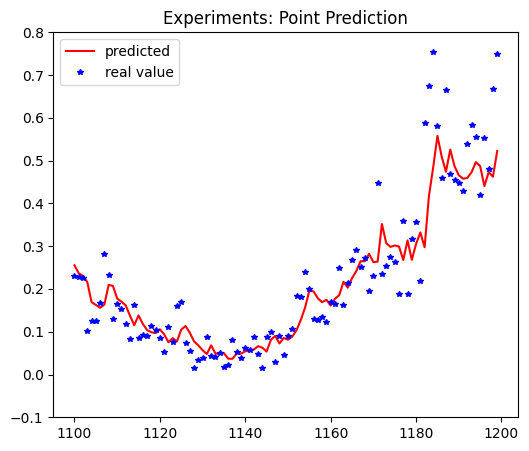

In [ ]:
# Plotting the results scaled as paper
start = 100  
end = 200

x = np.arange(1100, 1200)
mean_pred = preds[start:end]
true_points = trues[start:end]

plt.figure(figsize=(6, 5))
plt.plot(x, mean_pred, color='red', label="predicted")
plt.plot(x, true_points, 'b*', label="real value", markersize=4)

plt.ylim(-0.1, 0.8)
plt.title("Experiments: Point Prediction")
plt.legend()
plt.show()

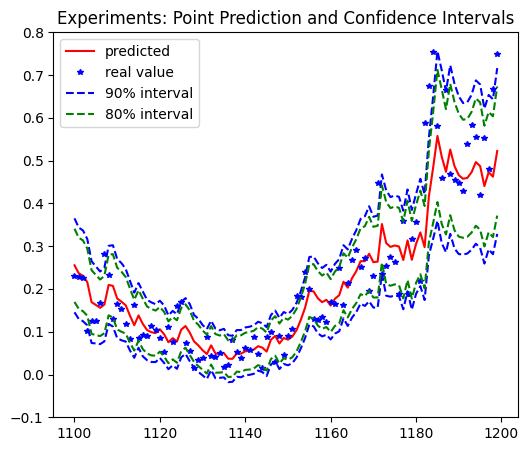

In [51]:
# Plotting confidence intervals as the paper 
# Z values for 90% and 80% intervals
z90 = norm.ppf(0.95)
z80 = norm.ppf(0.90)

std_pred = np.sqrt(vars_all[start:end])

# Calculate lower and upper bounds for 90% and 80% intervals
lower90 = mean_pred - z90 * std_pred
upper90 = mean_pred + z90 * std_pred

lower80 = mean_pred - z80 * std_pred
upper80 = mean_pred + z80 * std_pred

plt.figure(figsize=(6, 5))
plt.plot(x, mean_pred, color='red', label="predicted")
plt.plot(x, true_points, 'b*', label="real value", markersize=4)
plt.plot(x, lower90, 'b--', label="90% interval")
plt.plot(x, upper90, 'b--')
plt.plot(x, lower80, 'g--', label="80% interval")
plt.plot(x, upper80, 'g--')

plt.ylim(-0.1, 0.8)
plt.title("Experiments: Point Prediction and Confidence Intervals")
plt.legend()
plt.show()

## LSTM 

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super(SimpleLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x, h_c):
        out, (h, c) = self.lstm(x, h_c)
        y_hat = self.out(out)
        return y_hat, (h, c)

# Setup
model = SimpleLSTM(input_dim=1, hidden_dim=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 500
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_seq = X_batch.unsqueeze(-1)
        Y_seq = Y_batch.unsqueeze(-1)

        h_0 = torch.zeros(1, X_seq.size(0), model.hidden_dim)
        c_0 = torch.zeros(1, X_seq.size(0), model.hidden_dim)

        y_hat, _ = model(X_seq, (h_0, c_0))

        loss = criterion(y_hat, Y_seq)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")
        
# 1min

Epoch 1/500 | Train Loss: 0.0249
Epoch 100/500 | Train Loss: 0.0037
Epoch 200/500 | Train Loss: 0.0035
Epoch 300/500 | Train Loss: 0.0029
Epoch 400/500 | Train Loss: 0.0025
Epoch 500/500 | Train Loss: 0.0021


In [73]:
# Evaluation
model.eval()
preds = []
trues = []

with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        X_seq = X_batch.unsqueeze(-1)
        Y_seq = Y_batch.unsqueeze(-1)

        h_0 = torch.zeros(1, X_seq.size(0), model.hidden_dim)
        c_0 = torch.zeros(1, X_seq.size(0), model.hidden_dim)

        y_hat, _ = model(X_seq, (h_0, c_0))

        preds.append(y_hat.squeeze(-1))
        trues.append(Y_seq.squeeze(-1))

preds = torch.cat(preds, dim=0).squeeze(0).numpy()
trues = torch.cat(trues, dim=0).squeeze(0).numpy()

mae = np.mean(np.abs(preds - trues))
rmse = np.sqrt(np.mean((preds - trues)**2))

print(f"LSTM MAE: {mae:.4f} | RMSE: {rmse:.4f}") # MAE : 0.0470 | RMSE : 0.0638

LSTM MAE: 0.0555 | RMSE: 0.0794


#### Improved LSTM

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Preprocessing

values = df_filtered['Sunspots'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values).flatten()

# Split
train_seq = scaled_values[:1000]
test_seq = scaled_values[1000:2000]

# Sliding window function
def create_sequences(data, seq_len=20):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        Y.append(data[i+seq_len])
    return torch.tensor(X).unsqueeze(-1).float(), torch.tensor(Y).unsqueeze(-1).float()

# Create train and val sets
X_train, Y_train = create_sequences(train_seq, seq_len=20)
X_val, Y_val = create_sequences(test_seq, seq_len=20)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=32, shuffle=False)

# LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)             # out: [B, T, H]
        last_output = out[:, -1, :]       # last timestep
        return self.fc(last_output)       # [B, 1]

model = SimpleLSTM(input_dim=1, hidden_dim=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_batch, Y_batch in train_loader:
        pred = model(X_batch)
        loss = criterion(pred, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.6f}")

# Evaluation
model.eval()
preds = []
trues = []

with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        pred = model(X_batch)
        preds.append(pred)
        trues.append(Y_batch)

preds = torch.cat(preds, dim=0).squeeze().numpy()
trues = torch.cat(trues, dim=0).squeeze().numpy()

mae = np.mean(np.abs(preds - trues))
rmse = np.sqrt(np.mean((preds - trues)**2))

print(f"LSTM MAE: {mae:.4f} | RMSE: {rmse:.4f}")


/var/folders/q6/lcytr3pd0v71b1h5m0wkt4b40000gn/T/ipykernel_67607/208955055.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  return torch.tensor(X).unsqueeze(-1).float(), torch.tensor(Y).unsqueeze(-1).float()


Epoch 1/300 | Train Loss: 0.025180
Epoch 50/300 | Train Loss: 0.003692
Epoch 100/300 | Train Loss: 0.003566
Epoch 150/300 | Train Loss: 0.003460
Epoch 200/300 | Train Loss: 0.003457
Epoch 250/300 | Train Loss: 0.003459
Epoch 300/300 | Train Loss: 0.003372
LSTM MAE: 0.0454 | RMSE: 0.0635


### Comparison of Results

#### Paper Results

| Metric | Proposed | LSTM   |
|--------|----------|--------|
| MAE    | 0.0453   | 0.0524 |
| RMSE   | 0.0612   | 0.0739 |

#### Implementation

| Metric | Proposed | LSTM   |
|--------|----------|--------|
| MAE    | 0.0463   | 0.0470 |
| RMSE   | 0.0659   | 0.0638 |


#### Paper results
<p align="center">
  <img src="https://raw.githubusercontent.com/sarakpyny/CREST-Internship/main/img/rib_paper/result_paper.png" width="500"/>
</p>

#### Implementation

<p align="center">
  <img src="https://raw.githubusercontent.com/sarakpyny/CREST-Internship/main/img/rib_paper/result_implementation.png" width="490"/>
</p>


## RIB-LSTM

This is our idea of improving on the proposed paper's methode i.e. in paper they use RIB in GRU, but in this section we try to use RIB in LSTM.

In [21]:
class RIB_LSTM_Model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, z_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim

        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.prior = Prior(hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        # Use LSTMCell 
        self.lstm_cell = nn.LSTMCell(z_dim, hidden_dim)

    def forward(self, x_t, h_prev, c_prev):
        # Encoder
        mu_enc, logvar_enc = self.encoder(x_t, h_prev)
        z_t = reparameterize(mu_enc, logvar_enc)

        # Prior
        mu_prior, logvar_prior = self.prior(h_prev)

        # Decoder
        mu_dec, logvar_dec = self.decoder(z_t, h_prev)

        # Single LSTM step
        h_t, c_t = self.lstm_cell(z_t, (h_prev, c_prev))

        return {
            'z_t': z_t,
            'mu_enc': mu_enc, 'logvar_enc': logvar_enc,
            'mu_prior': mu_prior, 'logvar_prior': logvar_prior,
            'mu_dec': mu_dec, 'logvar_dec': logvar_dec,
            'h_t': h_t, 'c_t': c_t  
        }

In [22]:
# Initialize model
model = RIB_LSTM_Model(input_dim=1, hidden_dim=64, z_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.001)
beta = 0.005
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_batch, Y_batch in train_loader:
        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)
        c_t = torch.zeros(X_batch.size(0), model.hidden_dim)

        loss = 0.0
        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t, c_t)
            h_t = out['h_t']
            c_t = out['c_t']

            loss += rib_loss(out, y_t, beta=beta) 

        loss /= X_batch.size(1) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

# 5mins

Epoch 1/1000 | Train Loss: 1.0246
Epoch 100/1000 | Train Loss: -0.4036
Epoch 200/1000 | Train Loss: -0.4336
Epoch 300/1000 | Train Loss: -0.7053
Epoch 400/1000 | Train Loss: -1.2704
Epoch 500/1000 | Train Loss: -1.3682
Epoch 600/1000 | Train Loss: -1.4540
Epoch 700/1000 | Train Loss: -1.4366
Epoch 800/1000 | Train Loss: -1.5033
Epoch 900/1000 | Train Loss: -1.5184
Epoch 1000/1000 | Train Loss: -1.5284


In [83]:
# Evaluation
model.eval()

preds = []
trues = []
vars_all = []

with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)
        c_t = torch.zeros(X_batch.size(0), model.hidden_dim)

        pred_mu = []
        pred_var = []

        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t, c_t)
            h_t = out['h_t']
            c_t = out['c_t']

            mu_dec = out['mu_dec']
            logvar_dec = out['logvar_dec']

            pred_mu.append(mu_dec.squeeze(-1))
            pred_var.append(torch.exp(logvar_dec).squeeze(-1))

        pred_mu = torch.stack(pred_mu, dim=1)  # [1, T]
        pred_var = torch.stack(pred_var, dim=1)  # [1, T]

        preds.append(pred_mu)
        vars_all.append(pred_var)
        trues.append(Y_batch)

# concat single batch
preds = torch.cat(preds, dim=0).squeeze(0).numpy()  # [T]
trues = torch.cat(trues, dim=0).squeeze(0).numpy()
vars_all = torch.cat(vars_all, dim=0).squeeze(0).numpy()

# Calculate MAE, RMSE
mae = np.mean(np.abs(preds - trues))
rmse = np.sqrt(np.mean((preds - trues)**2))

print(f"Final RIB-LSTM MAE: {mae:.4f} | RMSE: {rmse:.4f}") # MAE : 0.0452 | RMSE : 0.0640

Final RIB-LSTM MAE: 0.0482 | RMSE: 0.0657


## Test Proposed Methode

#### Method: (RIB-VLSTM)

Instead of computing $ C_t $ via the standard forget and input gates, we sample:

$$
z_t \sim \mathcal{N}(\mu_{\text{enc}}(x_t, h_{t-1}), \operatorname{diag}(\sigma^2_{\text{enc}}(x_t, h_{t-1})))
\quad \text{and we set} \quad C_t := z_t
$$

#### Here:
- $ z_t $ is drawn from a learned encoder distribution conditioned on $ x_t $ and $ h_{t-1} $.
- The mean $ \mu_{\text{enc}} $ and variance $ \sigma^2_{\text{enc}} $ are computed by neural networks.
- This stochastic $ z_t $ acts as a compressed representation.

The output gate remains as in the standard LSTM:

$$
o_t = \sigma(W_o [h_{t-1}, x_t] + b_o)
$$

Then the hidden state is updated using $ z_t $ (now playing the role of $ C_t $):

$$
h_t = o_t \odot \tanh(z_t) \quad \Longleftrightarrow \quad h_t = o_t \odot \tanh(C_t)
$$


#### How $ z_t $ is Computed

- Given $ x_t $ and $ h_{t-1} $, the encoder network outputs:
  $$
  \mu_{\text{enc}}(x_t, h_{t-1}), \quad \sigma^2_{\text{enc}}(x_t, h_{t-1})
  $$

- We sample $ \epsilon \sim \mathcal{N}(0, I) $ and use the reparameterization trick:

  $$
  z_t = \mu_{\text{enc}}(x_t, h_{t-1}) + \sigma_{\text{enc}}(x_t, h_{t-1}) \odot \epsilon
  $$

- This ensures that gradients can flow through $ \mu_{\text{enc}} $ and $ \sigma_{\text{enc}} $ during training.


#### Variational IB Loss for LSTM

To train the IB-LSTM cell, we maximize a **variational lower bound** that balances:
- High predictive power
- Strong compression

The objective for a sequence of length $ T $ over $ N $ examples is:

$$
L_{\text{IB-LSTM}} = \frac{1}{N} \sum_{n=1}^{N} \left[ \sum_{t=1}^{T}
\mathbb{E}_{z_t \sim p(z_t \mid x_t, h_{t-1})} \left[
- \log q(y_t \mid z_t)
\right]
+ \beta \, \text{KL}(p(z_t \mid x_t, h_{t-1}) \parallel p_{\text{prior}}(z_t \mid h_{t-1}))
\right]
$$


#### Explanation:

- $ q(y_t \mid z_t) $ is the decoder that predicts the output at time $ t $ given $ z_t $.
- $ p(z_t \mid x_t, h_{t-1}) $ is the encoder distribution producing the posterior over $ z_t $.
- $ p_{\text{prior}}(z_t \mid h_{t-1}) $ is the approximate prior, for example a Gaussian conditioned only on $ h_{t-1} $:
  $$
  p_{\text{prior}}(z_t \mid h_{t-1}) = \mathcal{N}(\mu_{\text{prior}}(h_{t-1}), \operatorname{diag}(\sigma^2_{\text{prior}}(h_{t-1})))
  $$
- $ \beta $ controls the trade-off between compression and prediction.


In [17]:
class VIB_VLSTM_Model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, z_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim

        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.prior = Prior(hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        # Output gate:
        self.output_gate = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim)  

    def forward(self, x_t, h_prev):
        mu_enc, logvar_enc = self.encoder(x_t, h_prev)
        z_t = reparameterize(mu_enc, logvar_enc)

        mu_prior, logvar_prior = self.prior(h_prev)
        mu_dec, logvar_dec = self.decoder(z_t, h_prev)

        # Output gate: o_t = σ(Wo [h_prev, x_t])
        o_t = torch.sigmoid(self.output_gate(torch.cat([h_prev, x_t], dim=-1)))

        # Project z to hidden dim for tanh
        z_proj = self.z_to_hidden(z_t)

        h_t = o_t * torch.tanh(z_proj)

        return {
            'z_t': z_t,
            'mu_enc': mu_enc, 'logvar_enc': logvar_enc,
            'mu_prior': mu_prior, 'logvar_prior': logvar_prior,
            'mu_dec': mu_dec, 'logvar_dec': logvar_dec,
            'h_t': h_t
        }


In [132]:
model = VIB_VLSTM_Model(input_dim=1, hidden_dim=64, z_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.002)
beta = 0.005
num_epochs = 1000

# For numerical stability, put on device
LOG_2PI = torch.log(torch.tensor(2.0 * np.pi)).to(next(model.parameters()).device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_batch, Y_batch in train_loader:
        # Init hidden state
        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)

        # Move to device if needed
        h_t = h_t.to(X_batch.device)

        loss = 0.0
        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t)
            h_t = out['h_t']

            mu_dec = out['mu_dec'].squeeze(-1)
            logvar_dec = out['logvar_dec'].squeeze(-1)

            nll = 0.5 * (LOG_2PI + logvar_dec + ((y_t.squeeze(-1) - mu_dec) ** 2) / torch.exp(logvar_dec))
            nll = nll.mean()

            mu_enc = out['mu_enc']
            logvar_enc = out['logvar_enc']
            mu_prior = out['mu_prior']
            logvar_prior = out['logvar_prior']

            kl = 0.5 * torch.sum(
                logvar_prior - logvar_enc +
                (torch.exp(logvar_enc) + (mu_enc - mu_prior) ** 2) / torch.exp(logvar_prior) - 1,
                dim=-1
            ).mean()

            loss += nll + beta * kl

        loss /= X_batch.size(1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

# 4mins

Epoch 1/1000 | Train Loss: 0.9979
Epoch 100/1000 | Train Loss: -0.4802
Epoch 200/1000 | Train Loss: -1.3024
Epoch 300/1000 | Train Loss: -1.3931
Epoch 400/1000 | Train Loss: -1.4486
Epoch 500/1000 | Train Loss: -1.3595
Epoch 600/1000 | Train Loss: -1.4946
Epoch 700/1000 | Train Loss: -1.5060
Epoch 800/1000 | Train Loss: -1.5002
Epoch 900/1000 | Train Loss: -1.5046
Epoch 1000/1000 | Train Loss: -1.4924


In [ ]:
# Evaluation for VIB-VLSTM
model.eval()

preds = []
trues = []
vars_all = []
with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        h_t = torch.zeros(X_batch.size(0), model.hidden_dim)

        pred_mu = []
        pred_var = []

        for t in range(X_batch.size(1)):
            x_t = X_batch[:, t].unsqueeze(-1)
            y_t = Y_batch[:, t].unsqueeze(-1)

            out = model(x_t, h_t)
            h_t = out['h_t']

            mu_dec = out['mu_dec']
            logvar_dec = out['logvar_dec']

            pred_mu.append(mu_dec.squeeze(-1))
            pred_var.append(torch.exp(logvar_dec).squeeze(-1))

        pred_mu = torch.stack(pred_mu, dim=1)  # [batch, T]
        pred_var = torch.stack(pred_var, dim=1)

        preds.append(pred_mu)
        vars_all.append(pred_var)
        trues.append(Y_batch)

# Concatenate all batches
preds = torch.cat(preds, dim=0).numpy()
trues = torch.cat(trues, dim=0).numpy()
vars_all = torch.cat(vars_all, dim=0).numpy()

# Calculate metrics
mae = np.mean(np.abs(preds - trues))
rmse = np.sqrt(np.mean((preds - trues) ** 2))

print(f" RIB-VLSTM MAE: {mae:.4f} | RMSE: {rmse:.4f}") # MAE : 0.0466 | RMSE : 0.0649

 IB-LSTM MAE: 0.0477 | RMSE: 0.0671


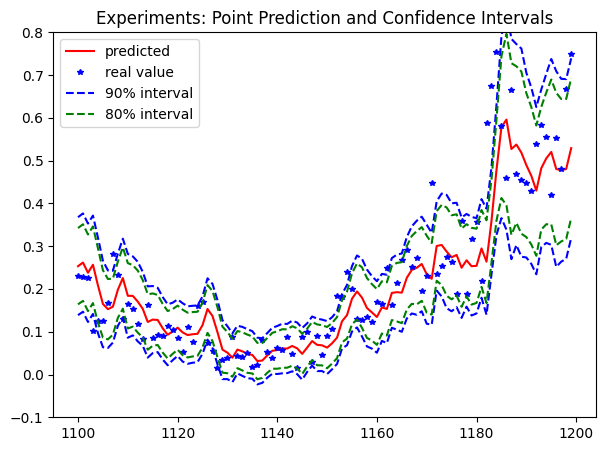

In [263]:
# Ensure inputs are 1D numpy arrays
mean_pred = np.array(preds).flatten()
true_points = np.array(trues).flatten()
std_pred = np.sqrt(np.array(vars_all).flatten())

# Define range safely
start, end = 100, min(200, len(mean_pred))
x = np.arange(1100, 1100 + (end - start))

# Slice
mean_pred = mean_pred[start:end]
true_points = true_points[start:end]
std_pred = std_pred[start:end]

# Confidence intervals
z90, z80 = norm.ppf(0.95), norm.ppf(0.90)
l90, u90 = mean_pred - z90*std_pred, mean_pred + z90*std_pred
l80, u80 = mean_pred - z80*std_pred, mean_pred + z80*std_pred

# Plot
plt.figure(figsize=(7, 5))
plt.plot(x, mean_pred, 'r', label="predicted")
plt.plot(x, true_points, 'b*', label="real value", markersize=4)
plt.plot(x, l90, 'b--', label="90% interval"); plt.plot(x, u90, 'b--')
plt.plot(x, l80, 'g--', label="80% interval"); plt.plot(x, u80, 'g--')
plt.ylim(-0.1, 0.8)
plt.title("Experiments: Point Prediction and Confidence Intervals")
plt.legend()
plt.show()


### Compares results

**Data set** 1000 for tranning and 1000 for testing

|          | IB-GRU(paper) | LSTM    | IB-LSTM(Our idea)    | Our idea   |
|----------|----------|--------|--------|--------|
| **MAE**  | 0.0463    | 0.0470 | 0.0452  | 0.0466 |
| **RMSE** | 0.0659   | 0.0638  | 0.0640  | 0.0649 |
